In [9]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Sequential

In [10]:
# Inherit from the Keras Layer class
class ProductMap(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def build(self, input_shape):
        pass
        
    def call(self, inputs):
        # Embed each feature "x" into vector [1 - x, x] and stack into a batch x features x 2 array
        output_1 = tf.vectorized_map(lambda x: 1-x, inputs)
        output_2 = tf.vectorized_map(lambda x: x, inputs)
        feature_matrix = tf.stack([output_1, output_2], axis = 2)
        return feature_matrix

In [11]:
# Images are retrieved, flattened, and normalized to the range [0, 1], labels are one-hot encoded
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape([60000, 28*28]) / 255
x_test = x_test.reshape([10000, 28*28]) / 255
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [12]:
class MPS_Layer_Improved(layers.Layer):

    def __init__(self, num_sites, bond_dim, num_output, **kwargs):
        super().__init__(**kwargs)
        self.n_half = num_sites // 2
        
        # Create variables for tensors to the left, right, and center of output site
        self.left = self.add_weight("left", initializer = self.initializer, shape = [2, self.n_half, bond_dim, bond_dim])
        self.right = self.add_weight("right", initializer = self.initializer, shape = [2, self.n_half, bond_dim, bond_dim])
        self.middle = self.add_weight("middle", initializer = self.initializer, shape = [1, num_output, bond_dim, bond_dim])[0]

    def call(self, inputs):
        left = tf.einsum("slij,bls->lbij", self.left, inputs[:, :self.n_half]) # Contract left tensors with data
        right = tf.einsum("slij,bls->lbij", self.right, inputs[:, self.n_half:]) # Contract right tensors with data
        left = self.reduction(left) # Contract left tensors together
        right = self.reduction(right) # Contract right tensors together
        outputs = tf.einsum("bij,cjk,bki->bc", left, self.middle, right) # Contract left and right with center
        return outputs

    @staticmethod
    def initializer(shape, dtype):
        # Tensors need to be initialized such that they basically act like the identity
        (phys_dim, num_sites, bond_dim, bond_dim) = shape
        matrices = phys_dim * num_sites*[tf.eye(bond_dim)]
        weights = tf.reshape(tf.stack(matrices), [phys_dim, num_sites, bond_dim, bond_dim])
        noised = weights + tf.random.normal(weights.shape, 0, 1e-2)
        return noised
    
    @staticmethod
    def reduction(tensor):
        # Takes a vector of matrices and contracts them together as a single product
        size = int(tensor.shape[0])
        while size > 1:
            half_size = size // 2
            nice_size = 2 * half_size
            leftover = tensor[nice_size:]
            tensor = tf.matmul(tensor[0:nice_size:2], tensor[1:nice_size:2])
            tensor = tf.concat([tensor, leftover], axis = 0)
            size = half_size + int(size % 2 == 1)
        return tensor[0]


In [5]:
num_features = x_train.shape[1]
bond_dim = 20

# Combine the ProductMap and MPS Layers into a sequential Keras model
model = Sequential()
model.add(ProductMap())
model.add(MPS_Layer_Improved(num_features, bond_dim, 10))

# Compile
model.compile(loss= tf.keras.losses.CategoricalCrossentropy(from_logits = True),
      optimizer=tf.keras.optimizers.RMSprop(0.0001),
      metrics=['accuracy'],
      run_eagerly = False)
#model.compile(optimizer='Adam',loss=tf.keras.losses.categorical_crossentropy,
#              metrics=['accuracy'])

In [6]:
epochs = 200
batch_size = 128

history = model.fit(x_train, y_train,
          batch_size= batch_size,
          epochs = epochs,
          verbose = 1,
          validation_data = (x_test, y_test))
score = model.evaluate(x_test, y_test, verbose = 0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/200
469/469 [==============================] - 35s 61ms/step - loss: 0.3927 - accuracy: 0.8780 - val_loss: 0.1687 - val_accuracy: 0.9477
Epoch 2/200
469/469 [==============================] - 25s 54ms/step - loss: 0.1470 - accuracy: 0.9562 - val_loss: 0.1211 - val_accuracy: 0.9629
Epoch 3/200
469/469 [==============================] - 24s 52ms/step - loss: 0.1064 - accuracy: 0.9684 - val_loss: 0.1043 - val_accuracy: 0.9695
Epoch 4/200
469/469 [==============================] - 25s 53ms/step - loss: 0.0835 - accuracy: 0.9743 - val_loss: 0.0978 - val_accuracy: 0.9708
Epoch 5/200
469/469 [==============================] - 26s 56ms/step - loss: 0.0689 - accuracy: 0.9786 - val_loss: 0.0919 - val_accuracy: 0.9732
Epoch 6/200
469/469 [==============================] - 26s 56ms/step - loss: 0.0600 - accuracy: 0.9818 - val_loss: 0.0826 - val_accuracy: 0.9757
Epoch 7/200
469/469 [==============================] - 25s 53ms/step - loss: 0.0515 - accuracy: 0.9836 - val_loss: 0.0910 - val_ac

Text(0, 0.5, 'Accuracy')

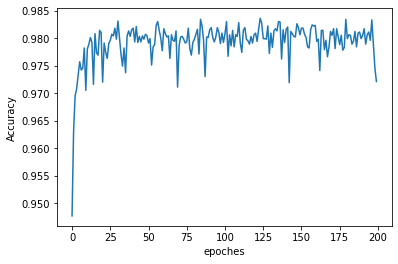

In [7]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoches')
plt.ylabel('Accuracy')

In [13]:
num_features = x_train.shape[1]
bond_dim = 6

# Combine the ProductMap and MPS Layers into a sequential Keras model
model = Sequential()
model.add(ProductMap())
model.add(MPS_Layer_Improved(num_features, bond_dim, 10))

# Compile
model.compile(loss= tf.keras.losses.CategoricalCrossentropy(from_logits = True),
      optimizer=tf.keras.optimizers.RMSprop(0.0001),
      metrics=['accuracy'],
      run_eagerly = False)
#model.compile(optimizer='Adam',loss=tf.keras.losses.categorical_crossentropy,
#              metrics=['accuracy'])

In [14]:
epochs = 200
batch_size = 128

history = model.fit(x_train, y_train,
          batch_size= batch_size,
          epochs = epochs,
          verbose = 1,
          validation_data = (x_test, y_test))
score = model.evaluate(x_test, y_test, verbose = 0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/200
469/469 [==============================] - 11s 15ms/step - loss: 0.6820 - accuracy: 0.7857 - val_loss: 0.3930 - val_accuracy: 0.8869
Epoch 2/200
469/469 [==============================] - 6s 13ms/step - loss: 0.3556 - accuracy: 0.8945 - val_loss: 0.2832 - val_accuracy: 0.9172
Epoch 3/200
469/469 [==============================] - 6s 13ms/step - loss: 0.2837 - accuracy: 0.9171 - val_loss: 0.2451 - val_accuracy: 0.9314
Epoch 4/200
469/469 [==============================] - 6s 13ms/step - loss: 0.2400 - accuracy: 0.9294 - val_loss: 0.2230 - val_accuracy: 0.9366
Epoch 5/200
469/469 [==============================] - 7s 15ms/step - loss: 0.2102 - accuracy: 0.9391 - val_loss: 0.2017 - val_accuracy: 0.9420
Epoch 6/200
469/469 [==============================] - 6s 14ms/step - loss: 0.1884 - accuracy: 0.9452 - val_loss: 0.2000 - val_accuracy: 0.9437
Epoch 7/200
469/469 [==============================] - 6s 13ms/step - loss: 0.1742 - accuracy: 0.9502 - val_loss: 0.1712 - val_accuracy

Text(0, 0.5, 'Accuracy')

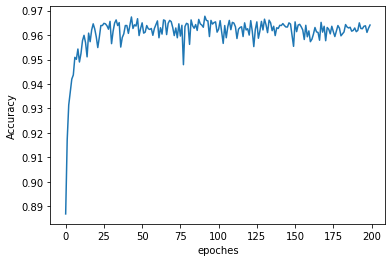

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoches')
plt.ylabel('Accuracy')

In [16]:
num_features = x_train.shape[1]
bond_dim = 10

# Combine the ProductMap and MPS Layers into a sequential Keras model
model = Sequential()
model.add(ProductMap())
model.add(MPS_Layer_Improved(num_features, bond_dim, 10))

# Compile
model.compile(loss= tf.keras.losses.CategoricalCrossentropy(from_logits = True),
      optimizer=tf.keras.optimizers.RMSprop(0.0001),
      metrics=['accuracy'],
      run_eagerly = False)
#model.compile(optimizer='Adam',loss=tf.keras.losses.categorical_crossentropy,
#              metrics=['accuracy'])

In [17]:
epochs = 200
batch_size = 128

history = model.fit(x_train, y_train,
          batch_size= batch_size,
          epochs = epochs,
          verbose = 1,
          validation_data = (x_test, y_test))
score = model.evaluate(x_test, y_test, verbose = 0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/200
469/469 [==============================] - 15s 23ms/step - loss: 0.5142 - accuracy: 0.8384 - val_loss: 0.2721 - val_accuracy: 0.9221
Epoch 2/200
469/469 [==============================] - 10s 22ms/step - loss: 0.2377 - accuracy: 0.9286 - val_loss: 0.1931 - val_accuracy: 0.9444
Epoch 3/200
469/469 [==============================] - 11s 23ms/step - loss: 0.1758 - accuracy: 0.9467 - val_loss: 0.1446 - val_accuracy: 0.9578
Epoch 4/200
469/469 [==============================] - 10s 22ms/step - loss: 0.1413 - accuracy: 0.9574 - val_loss: 0.1419 - val_accuracy: 0.9576
Epoch 5/200
469/469 [==============================] - 10s 22ms/step - loss: 0.1197 - accuracy: 0.9633 - val_loss: 0.1241 - val_accuracy: 0.9619
Epoch 6/200
469/469 [==============================] - 10s 22ms/step - loss: 0.1041 - accuracy: 0.9680 - val_loss: 0.1339 - val_accuracy: 0.9613
Epoch 7/200
469/469 [==============================] - 10s 21ms/step - loss: 0.0938 - accuracy: 0.9707 - val_loss: 0.1261 - val_ac

Text(0, 0.5, 'Accuracy')

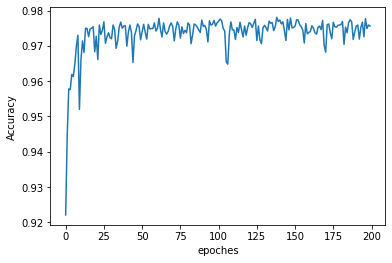

In [18]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoches')
plt.ylabel('Accuracy')